In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [44]:
img = cv2.imread('cameraman.png', 0) # reading image
img = img[20:148, 160:224] # ROI
filter = np.array([[0, 0, 0],[-1, 0, 1], [0, 0, 0]]) # filter to find diff in x & y direction
grad_x = np.flipud(cv2.filter2D(img, -1, filter)) # finding x gradients
grad_y = np.flipud(cv2.filter2D(img, -1, filter.T)) # finding x gradients
eps = 1e-10 # to avoid devision by zero we add eps to divisor
magnitude = np.sqrt(grad_x**2 + grad_y**2) # magnitude(µ)
angle = np.arctan(abs(grad_y/(grad_x+eps))) # theta(θ)

In [45]:
img.shape ## 2 gradients will be added bacause of convolution

(128, 64)

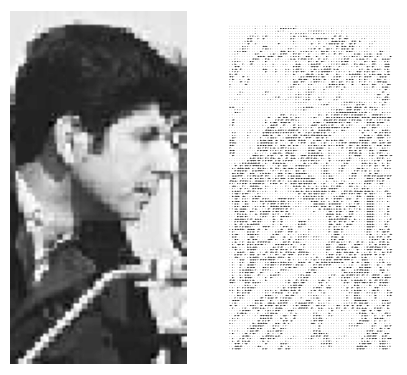

In [76]:
plt.figure(figsize=(5, 6))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(img, 'gray')
ax = plt.gca()
# ratio_default=(ax.get_xlim()[1]-ax.get_xlim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]).copy()
ax.set_aspect(1)
plt.subplot(1,2,2)
ax = plt.gca()
ax.set_aspect(1)
plt.quiver(magnitude, angle)
plt.axis(False);

In [37]:
# this function calculates histogram in each cell.
def cell_hist(angle, magnitude, nbin):
    hist = np.zeros(nbin+1) # preallocating each histogram
    bins = np.arange(0, np.pi + (np.pi / nbin
                                 ), np.pi / nbin) # creating all bins (possible angles)
    angles = angle.reshape(angle.size, 1) @ np.ones((1, nbin + 1)) # repeating angles so we can find the nearest bin without for loop
    diff = np.abs(angles-bins)
    id = np.argmin(diff, axis = 1) # finding nearest bin
    diff[:, id] = np.inf
    id1 = np.argmin(diff, axis = 1) # finding second nearest bin
    hist[id] += (1 - (np.abs(angle.ravel() - bins[id])/(np.pi/nbin))) * magnitude.ravel() # adding evaluated values to nearest bin
    hist[id1] += (np.abs(angle.ravel() - bins[id])/(np.pi/nbin)) * magnitude.ravel() # adding evaluated values to second nearest bin
    hist[0] += hist[-1] # adding 180 degree values to 0 (they are the same bin with two angles)
    hist = hist[:-1] # deleting the last bin since it doesn't really exist.
    return hist    

In [38]:
def hog(angle, magnitude, nbins = 9, cellSize = (8, 8), blockSize = (2, 2)):
    # vec is our result that needs to be filled.
    vec = np.empty(nbins * np.prod(blockSize) * ((angle.shape[0]//cellSize[0])-\
                                                 blockSize[0]+1) * ((angle.shape[1]//cellSize[1])-blockSize[1]+1))


    angle
    magnitude
    nblock = ((angle.shape[0]//cellSize[0]) - blockSize[0] + 1, (angle.shape[1]//cellSize[1]) - blockSize[1] + 1)

    n = 0 #block counter
    for i in range(nblock[0]):
        for j in range(nblock[1]):
            # selecting a block
            ang_temp = angle[i * blockSize[0] * cellSize[0]:(i+1) * blockSize[0] * cellSize[0],\
                             j * blockSize[0] * cellSize[0]:(j+1) * blockSize[0] * cellSize[0]]
            mag_temp = magnitude[i * blockSize[0] * cellSize[0]:(i+1) * blockSize[0] * cellSize[0],\
                                 j * blockSize[0] * cellSize[0]:(j+1) * blockSize[0] * cellSize[0]]
            v = np.empty((nbins*np.prod(blockSize)), dtype="float")
            m = 0 # histogram counter(counts each block's cell bins for nomalization)
            for ii in range(blockSize[0]):
                for jj in range(blockSize[1]):
                    v[m*nbins:(m+1)*nbins] = cell_hist(
                    ang_temp[ii*cellSize[0]:(ii+1) * cellSize[0],\
                             jj*cellSize[1]:(jj+1) * cellSize[0]],
                    mag_temp[ii*cellSize[0]:(ii+1) * cellSize[0],\
                             jj*cellSize[1]:(jj+1) * cellSize[0]], nbins)
                    m += 1
            v = v / np.sqrt(np.sum(v**2) + 1e-10)
            vec[n*np.prod(blockSize)*nbins:(n+1)*np.prod(blockSize)*nbins] = v
            n += 1
    return vec

In [39]:
hist = hog(angle, magnitude)